<a href="https://colab.research.google.com/github/matlogica/AADC-Python/blob/main/QuantLib/xVA/xVA-QL-Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AADC enabled C++ QuantLib xVA benchmark


### The benchmark is based on xVA example from here:

https://raw.githubusercontent.com/carljohanrehn/quantlib-xva/master/quantlib-xva/firstdraft.py

== Small change is applied to update to QuantLib version 1.33

== Code is modified to perform 5000 MC simulations.

== Original code is in xVA-QL-Original.ipynb and it runs in about 35seconds, this version runs in 0.1 seconds AND computes all sensitivities.


This Python module calculates the Credit Value Adjustment for a single netting set of plain vanilla
interest rate swaps.

The code is based on the IPython Notebook of Matthias Groncki (see reference below).

References:

"CVA Calculation with QuantLib and Python", Matthias Groncki
    - https://ipythonquant.wordpress.com/tag/cva/
    - http://nbviewer.ipython.org/github/mgroncki/IPythonScripts/blob/master/CVA_calculation_I.ipynb

"FOOLING AROUND WITH QUANTLIB: GSR MODEL", Peter Caspers:
    - https://quantlib.wordpress.com/tag/gsr-model/

"One Factor Gaussian Short Rate Model Implementation", Peter Caspers, March 1, 2013:
    - http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2246013


Install AADC enabled QuantLib

In [1]:
!pip install https://matlogica.com/DemoReleases/aadc-1.7.5.2401-cp310-cp310-linux_x86_64.whl

  Using cached https://matlogica.com/DemoReleases/aadc-1.7.5.2401-cp310-cp310-linux_x86_64.whl (35.1 MB)


In [2]:
from time import perf_counter as pc

import aadc
import numpy as np

ql = aadc.QuantLib

## Next code is taken from original sources and unmodified

In [3]:
def get_version():
    return list(map(int, ql.__version__.split(".")))


# General QuantLib functions...
def set_evaluation_date(date):
    ql.Settings.instance().evaluationDate = date

def link_to_curve(relinkable_handle, curve):
    return relinkable_handle.linkTo(curve)


In [4]:
# Random numbers...
def create_random_number_generator(evaluation_time_grid, seed=1):
    uniform_rng = ql.MersenneTwisterUniformRng(seed)
    uniform_rsg = ql.MersenneTwisterUniformRsg(len(evaluation_time_grid) - 1, uniform_rng)

    return ql.InvCumulativeMersenneTwisterGaussianRsg(uniform_rsg)


# Default curve...
def create_default_curve(default_dates, hazard_rates, day_count=ql.Actual365Fixed()):
    default_curve = ql.HazardRateCurve(default_dates, hazard_rates, day_count)
    default_curve.enableExtrapolation()

    return default_curve


def get_default_probability(times, default_curve):
    # TODO ...
    # torch.FloatTensor(default_curve.defaultProbability)

    return np.vectorize(default_curve.defaultProbability)(times)


def get_survival_probability(times, default_curve):
    return np.vectorize(default_curve.survivalProbability)(times)


def get_default_density(times, default_curve):
    return np.vectorize(default_curve.defaultDensity)(times)


def get_hazard_rate(times, default_curve):
    """

    @param times:
    @param default_curve:
    @return:
    """

    return np.vectorize(default_curve.hazardRate)(times)


def calculate_default_probability_grid(evaluation_time_grid, default_curve):
    return np.vectorize(default_curve.defaultProbability)(evaluation_time_grid[:-1], evaluation_time_grid[1:])


# Discount curve...
def create_flat_forward(todays_date, rate, day_count=ql.Actual365Fixed()):
    flat_forward = ql.FlatForward(todays_date, ql.QuoteHandle(rate), day_count)
    flat_forward.enableExtrapolation()

    return flat_forward, ql.YieldTermStructureHandle(flat_forward), ql.RelinkableYieldTermStructureHandle(flat_forward)


def generate_discount_factors(flat_forward_handle, evaluation_time_grid):
    #    return np.vectorize(flat_forward_handle.discount)(evaluation_time_grid)
    return np.vectorize(flat_forward_handle.currentLink().discount)(evaluation_time_grid)


def get_discount_curve(curve_dates, discount_factors, day_count_convention=ql.Actual365Fixed()):
    discount_curve = ql.DiscountCurve(curve_dates, discount_factors, day_count_convention)

    discount_curve.enableExtrapolation()

    return discount_curve


# Pricing engine...
def create_pricing_engine(flat_forward_relinkable_handle):
    return ql.DiscountingSwapEngine(flat_forward_relinkable_handle)


# Swap portfolio...
def create_plain_vanilla_swap(
    start_date,
    maturity_date,
    nominal_amount,
    float_index,
    fixed_rate,
    #                              fixed_leg_tenor=ql.Period("1y"),
    fixed_leg_tenor=ql.PeriodParser.parse("1y"),
    fixed_leg_business_day_convention=ql.ModifiedFollowing,
    fixed_leg_day_count_convention=ql.Thirty360(ql.Thirty360.BondBasis),
    calendar=ql.Sweden(),
    spread=0.0,
    swap_type=ql.VanillaSwap.Payer,
):
    end_date = calendar.advance(start_date, maturity_date)

    fixed_schedule = ql.Schedule(
        start_date,
        end_date,
        fixed_leg_tenor,
        float_index.fixingCalendar(),
        fixed_leg_business_day_convention,
        fixed_leg_business_day_convention,
        ql.DateGeneration.Backward,
        False,
    )

    float_schedule = ql.Schedule(
        start_date,
        end_date,
        float_index.tenor(),
        float_index.fixingCalendar(),
        float_index.businessDayConvention(),
        float_index.businessDayConvention(),
        ql.DateGeneration.Backward,
        False,
    )

    swap = ql.VanillaSwap(
        swap_type,
        nominal_amount,
        fixed_schedule,
        fixed_rate,
        fixed_leg_day_count_convention,
        float_schedule,
        float_index,
        spread,
        float_index.dayCounter(),
    )

    return swap, [float_index.fixingDate(x) for x in float_schedule][:-1]


def make_simple_portfolio(
    list_of_start_dates,
    list_of_maturity_dates,
    list_of_nominal_amounts,
    list_of_float_indices,
    list_of_fixed_rates,
    list_of_swap_types,
):
    simple_portfolio = []

    for start_date, maturity_date, nominal_amount, float_index, fixed_rate, swap_type in zip(
        list_of_start_dates,
        list_of_maturity_dates,
        list_of_nominal_amounts,
        list_of_float_indices,
        list_of_fixed_rates,
        list_of_swap_types,
    ):
        simple_portfolio.append(
            create_plain_vanilla_swap(
                start_date, maturity_date, nominal_amount, float_index, fixed_rate, swap_type=swap_type
            )
        )

    return simple_portfolio


def calculate_portfolio_npv(flat_forward_relinkable_handle, portfolio):
    engine = create_pricing_engine(flat_forward_relinkable_handle)

    portfolio_npv = []
    for deal, _ in portfolio:
        deal.setPricingEngine(engine)
        portfolio_npv.append(deal.NPV())

    return portfolio_npv


# Evaluation grid, curve dates, and NPV matrix...
def define_evaluation_grid(todays_date, simple_portfolio, number_of_months=12 * 6):
    evaluation_dates_grid = [todays_date + ql.Period(i_month, ql.Months) for i_month in range(number_of_months)]

    for deal in simple_portfolio:
        evaluation_dates_grid += deal[1]

    evaluation_dates_grid = np.unique(np.sort(evaluation_dates_grid))

    evaluation_time_grid = np.vectorize(
        lambda x: ql.ActualActual(ql.ActualActual.ISDA).yearFraction(
            todays_date, x
        )  # empty constructor doesn't exist???
    )(evaluation_dates_grid)

    # diff_evaluation_time_grid = evaluation_time_grid[1:] - evaluation_time_grid[:-1]

    return evaluation_dates_grid, evaluation_time_grid  # , diff_evaluation_time_grid


def define_curve_dates(date, n_years=10):
    # append first half year to date
    curve_dates = [date, date + ql.Period(6, ql.Months)]

    curve_dates += [date + ql.Period(i_year, ql.Years) for i_year in range(1, n_years + 1)]

    return curve_dates


# TODO ...
def create_npv_matrix(
    todays_date,
    number_of_paths,
    evaluation_dates_grid,
    simple_portfolio,
    flat_forward,
    flat_forward_relinkable_handle,
    zero_bonds,
    float_index,
):
    n_dates, n_deals = len(evaluation_dates_grid), len(simple_portfolio)

    npv_matrix = np.zeros((number_of_paths, n_dates, n_deals))

    for i_path in range(number_of_paths):
        print("pricing ", i_path)
        for i_date in range(n_dates):
            date = evaluation_dates_grid[i_date]

            discount_curve = get_discount_curve(define_curve_dates(date), zero_bonds[i_path, i_date, :])

            #            set_evaluation_date(date)
            ql.Settings().evaluationDate = date
            link_to_curve(flat_forward_relinkable_handle, discount_curve)

            # TODO Check... is this correct?
            is_valid_fixing_date = float_index.isValidFixingDate(date)

            if is_valid_fixing_date:
                fixing = float_index.fixing(date)
                float_index.addFixing(date, fixing)

            for i_deal in range(n_deals):
                npv_matrix[i_path, i_date, i_deal] = simple_portfolio[i_deal][0].NPV()

        ql.IndexManager.instance().clearHistories()

    set_evaluation_date(todays_date)
    link_to_curve(flat_forward_relinkable_handle, flat_forward)

    return npv_matrix


def calculate_discounted_npv_matrix(npv_matrix, discount_factors):
    discounted_npv_matrix = np.zeros(npv_matrix.shape)

    for i in range(npv_matrix.shape[2]):
        discounted_npv_matrix[:, :, i] = npv_matrix[:, :, i] * discount_factors

    return discounted_npv_matrix


# Gsr model and simulation of paths...
def generate_gsr_model(
    flat_forward_handle, volatility_step_dates, volatilities, mean_reversion, forward_measure_time=16.0
):
    return ql.Gsr(flat_forward_handle, volatility_step_dates, volatilities, mean_reversion, forward_measure_time)


def generate_paths(number_of_paths, evaluation_time_grid, tenors, inv_cumulative_gaussian_rsg, model):
    n_tenors = len(tenors)

    diff_evaluation_time_grid = evaluation_time_grid[1:] - evaluation_time_grid[:-1]

    x = np.zeros((number_of_paths, len(evaluation_time_grid)))
    y = np.zeros((number_of_paths, len(evaluation_time_grid)))

    zero_bonds = np.zeros((number_of_paths, len(evaluation_time_grid), n_tenors))

    for j_tenor in range(n_tenors):
        zero_bonds[:, 0, j_tenor] = model.zerobond(tenors[j_tenor], 0, 0)

    process = model.stateProcess()

    for n_path in range(number_of_paths):
        print("model path ", n_path)

        next_sequence = inv_cumulative_gaussian_rsg.nextSequence().value  # value() is exteded from swig layer

        next_sequence_arg = [x.mark_as_input_no_diff() for x in next_sequence]

        for i_time in range(1, len(evaluation_time_grid)):
            t_start = evaluation_time_grid[i_time - 1]
            t_end = evaluation_time_grid[i_time]

            x[n_path, i_time] = process.expectation(
                t_start, x[n_path, i_time - 1], diff_evaluation_time_grid[i_time - 1]
            ) + next_sequence[i_time - 1] * process.stdDeviation(
                t_start, x[n_path, i_time - 1], diff_evaluation_time_grid[i_time - 1]
            )

            # y equals standardized x (see Gsr-paper by Caspers and Gsr model in QuantLib)
            y[n_path, i_time] = (x[n_path, i_time] - process.expectation(0, 0, t_end)) / process.stdDeviation(
                0, 0, t_end
            )

            for j_tenor in range(n_tenors):
                zero_bonds[n_path, i_time, j_tenor] = model.zerobond(t_end + tenors[j_tenor], t_end, y[n_path, i_time])

    return x, zero_bonds, next_sequence_arg


# Netting, exposure, and CVA...
def calculate_netted_npv_matrix(npv_matrix):
    return np.sum(npv_matrix, axis=2)


def calculate_exposure(portfolio_npv):
    if aadc.is_recording():
        exposure = portfolio_npv.copy()
        for i in range(len(exposure)):
            for j in range(len(exposure[i])):
                exposure[i][j] = aadc.math.max(exposure[i][j], 0.0)
        return exposure
    #    exposure = portfolio_npv.copy()
    #    exposure[exposure < 0] = 0
    zeros = np.zeros(portfolio_npv.shape)
    exposure = np.maximum(portfolio_npv, zeros)

    return exposure


def calculate_expected_exposure(portfolio_npv, number_of_paths):
    return np.sum(calculate_exposure(portfolio_npv), axis=1) / number_of_paths


def calculate_potential_future_exposure(exposure, number_of_paths, quantile=0.95):
    # TODO Should we have ceil here?
    potential_future_exposure = np.apply_along_axis(
        lambda x: np.sort(x)[int(np.ceil(quantile * number_of_paths))], 0, exposure
    )

    # Alternative formulation: use max of each exposure path
    # potential_future_exposure = np.sort(np.max(exposure, axis=1))[quantile * number_of_paths]

    return potential_future_exposure


def calculate_economic_cva(expected_discounted_exposure, default_probabilities, recovery_rate=0.4):
    return (1 - recovery_rate) * np.sum(expected_discounted_exposure[1:] * default_probabilities)


# Next we initialize recording of 1 MonteCarlo path

In [5]:
    # Set evaluation date...
    # todays_date = ql.Date(7, 4, 2015)
    todays_date = ql.Date(13, 8, 2015)
    # ql.Settings.instance().setEvaluationDate(todays_date)
    set_evaluation_date(todays_date)

AADC overrides help with numpy compatibility

In [6]:
import aadc.overrides

In [7]:
    funcs = aadc.Functions()
    funcs.start_recording()

In [8]:
    # Market data...
    rate_value = aadc.idouble(0.03)
    rate_arg = rate_value.mark_as_input()

    rate = ql.SimpleQuote(rate_value)

    flat_forward, flat_forward_handle, flat_forward_relinkable_handle = create_flat_forward(todays_date, rate)

    print(rate.value())
    print(flat_forward.discount(10))

    euribor6m = ql.Euribor6M(flat_forward_relinkable_handle)

idouble([AAD[rv] [adj] :8,3.00e-02])
idouble([AAD[rv] [adj] :8,7.41e-01])


In [9]:
    # Create simple swap portfolio...
    list_of_start_dates = [todays_date + ql.PeriodParser.parse("2d"), todays_date + ql.PeriodParser.parse("2d")]

    list_of_maturity_dates = [ql.PeriodParser.parse(years) for years in ["5Y", "4Y"]]

    list_of_nominal_amounts = [1e6, 5e5]
    list_of_float_indices = [euribor6m, euribor6m]
    list_of_fixed_rates = [0.03, 0.03]

    list_of_swap_types = [ql.VanillaSwap.Payer, ql.VanillaSwap.Receiver]

    simple_portfolio = make_simple_portfolio(
        list_of_start_dates,
        list_of_maturity_dates,
        list_of_nominal_amounts,
        list_of_float_indices,
        list_of_fixed_rates,
        list_of_swap_types,
    )

In [10]:
    portfolio_npv = calculate_portfolio_npv(flat_forward_relinkable_handle, simple_portfolio)

In [11]:
    # Instantiate the Gsr model...

    volatility_step_dates = [todays_date + 100]

    ivolatilities = [0.0075, 0.0075]
    ivolatilities = [aadc.idouble(x) for x in ivolatilities]
    volatilities_arg = [x.mark_as_input() for x in ivolatilities]
    volatilities = [ql.QuoteHandle(ql.SimpleQuote(x)) for x in ivolatilities]

In [12]:
    mean_reversion = [ql.QuoteHandle(ql.SimpleQuote(0.02))]
    #    mean_reversion = [ql.QuoteHandle(ql.SimpleQuote(0.02))]

    gsr_model = generate_gsr_model(
        flat_forward_handle, volatility_step_dates, volatilities, mean_reversion, forward_measure_time=16.0
    )

    # Create evaluation grid and simulate paths (using the Gsr model)...

    evaluation_dates_grid, evaluation_time_grid = define_evaluation_grid(todays_date, simple_portfolio)

    inv_cumulative_gaussian_rsg = create_random_number_generator(evaluation_time_grid)

### Unlike original code, here we set number of paths to 1

In [13]:
    number_of_paths = 1

In [14]:
tenors = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

with aadc.overrides.aadc_overrides():
    x, zero_bonds, next_sequence_arg = generate_paths(
        number_of_paths, evaluation_time_grid, tenors, inv_cumulative_gaussian_rsg, gsr_model
    )

model path  0


In [15]:
with aadc.overrides.aadc_overrides():
    # Create the discounted NPV matrix...
    npv_matrix = create_npv_matrix(
        todays_date,
        number_of_paths,
        evaluation_dates_grid,
        simple_portfolio,
        flat_forward,
        flat_forward_relinkable_handle,
        zero_bonds,
        euribor6m,
    )

pricing  0


In [16]:
with aadc.overrides.aadc_overrides():
    discount_factors = generate_discount_factors(flat_forward_handle, evaluation_time_grid)

    discounted_npv_cube = calculate_discounted_npv_matrix(npv_matrix, discount_factors)

In [17]:
    portfolio_npv = calculate_netted_npv_matrix(npv_matrix)
    discounted_portfolio_npv = calculate_netted_npv_matrix(discounted_npv_cube)

    print(discounted_portfolio_npv[0][range(0,10)])


aadc.array([idouble([AAD[rv] [adj] :6692,1.24e+03]),
       idouble([AAD[rv] [adj] :6671,-6.01e+01]),
       idouble([AAD[rv] [adj] :6699,1.40e+04]),
       idouble([AAD[rv] [adj] :1475,1.68e+04]),
       idouble([AAD[rv] [adj] :1458,2.41e+04]),
       idouble([AAD[rv] [adj] :1477,5.15e+03]),
       idouble([AAD[rv] [adj] :5785,-7.34e+02]),
       idouble([AAD[rv] [adj] :5766,-1.51e+03]),
       idouble([AAD[rv] [adj] :5788,1.04e+04]),
       idouble([AAD[rv] [adj] :2687,-9.13e+03])], dtype=object)


In [18]:
    exposure = calculate_exposure(portfolio_npv)
    discounted_exposure = calculate_exposure(discounted_portfolio_npv)
    discounted_neg_exposure = calculate_exposure(-discounted_portfolio_npv)


In [19]:
    default_dates = [todays_date + ql.Period(i_year, ql.Years) for i_year in range(11)]
    hazard_rates = [aadc.idouble(0.02 * i_year) for i_year in range(11)]
    hazard_rates_arg = [x.mark_as_input() for x in hazard_rates]

    default_curve = create_default_curve(default_dates, hazard_rates)

In [20]:
    # Calculate default probabilities...
    default_probabilities = calculate_default_probability_grid(evaluation_time_grid, default_curve)

In [21]:
    if aadc.is_recording():
        discounted_exposure = discounted_exposure[0]
        discounted_neg_exposure = discounted_neg_exposure[0]

In [22]:
    # Calculation of the CVA...
    economic_cva = calculate_economic_cva(discounted_exposure, default_probabilities, recovery_rate=0.4)
    economic_dva = calculate_economic_cva(discounted_neg_exposure, default_probabilities, recovery_rate=0.4)
    print(economic_cva)
    print(economic_dva)

idouble([AAD[rv] [adj] :6770,8.20e+01])
idouble([AAD[rv] [adj] :5879,1.68e+03])


In [23]:
    portfolio_npv_res = [
        aadc.idouble(x).mark_as_output() for x in portfolio_npv[0]
    ]  # path 0  some elements are zero floats => aadc.idouble(x)
    discounted_portfolio_npv_res = [x.mark_as_output() for x in discounted_portfolio_npv[0]]
    economic_cva_res = economic_cva.mark_as_output()
    economic_dva_res = economic_dva.mark_as_output()

In [24]:
funcs.stop_recording()

### Next command checks for recording consistency. If number of active to passive conversions is zero, we didn't miss any branches and can use Kernel with arbitrary inputs.

In [25]:
    funcs.print_passive_extract_locations()

In [71]:
# This command can be used to get Kernel statistics
#    print(funcs.recording_stats("Python"))


## AADC Kernel is recorded and can be used to process multiple simulations

In [26]:
    number_of_paths = 5000

### Set inputs. Note that market data is scalar, but can be np arrays to process multiple scenarios.

In [27]:
    inputs = {}
    inputs[rate_arg] = rate_value
    for i in range(len(volatilities)):
        inputs[volatilities_arg[i]] = ivolatilities[i]
    for i in range(len(hazard_rates)):
        inputs[hazard_rates_arg[i]] = hazard_rates[i]
    randoms = np.zeros((number_of_paths, len(next_sequence_arg)))


### Generate all necessary random numbers. This step can be further optimized or cached

In [28]:
    # create new random generator
    print("Generating randoms...")
    time_rngen = pc()
    inv_cumulative_gaussian_rsg = create_random_number_generator(evaluation_time_grid)
    #    inv_cumulative_gaussian_rsg.nextSequence()
    for i in range(number_of_paths):
        next_sequence = inv_cumulative_gaussian_rsg.nextSequence().value
        randoms[i, :] = next_sequence

    for i in range(len(next_sequence_arg)):
        inputs[next_sequence_arg[i]] = randoms[:, i]

    print("randoms generation time = ", pc() - time_rngen)

Generating randoms...
randoms generation time =  1.2005135019999216


### Prepare request object. Here we want cva/dva values and their sensitivities

In [29]:
    request = {
        economic_cva_res: [rate_arg] + volatilities_arg + hazard_rates_arg,
        economic_dva_res: [rate_arg] + volatilities_arg + hazard_rates_arg,
    }

### We also want to get portfolio values to calculate Expected Exposure

In [30]:
    for i in range(len(discounted_portfolio_npv_res)):
        request[discounted_portfolio_npv_res[i]] = []


### Running simulations. Here we use avx2 and 1 CPU core

In [31]:
    print("Running simulation...")
    t0 = pc()
    results = aadc.evaluate(funcs, request, inputs, aadc.ThreadPool(1))
    print("evaluation time = ", pc() - t0)

Running simulation...
evaluation time =  0.7156923990000905


### Compare this with using 4 CPU cores. Note that QL isn't MT safe, but AADC Kernels are.

In [32]:
    print("Running simulation...")
    t0 = pc()
    results = aadc.evaluate(funcs, request, inputs, aadc.ThreadPool(4))
    print("evaluation time = ", pc() - t0)


Running simulation...
evaluation time =  0.5675848289999976


In [33]:
    print("CVA:", np.average(results[0][economic_cva_res]))
    print("DVA:", np.average(results[0][economic_dva_res]))

CVA: 627.5282798805566
DVA: 1502.2034089410563


In [34]:
    for i in range(len(volatilities_arg)):
        print("dCVA/dVol[", i, "]:", np.average(results[1][economic_cva_res][volatilities_arg[i]]))
    for i in range(len(hazard_rates_arg)):
        print("dCVA/dHazR[", i, "]:", np.average(results[1][economic_cva_res][hazard_rates_arg[i]]))

dCVA/dVol[ 0 ]: 10692.44526851851
dCVA/dVol[ 1 ]: 68994.5232733822
dCVA/dHazR[ 0 ]: 0.0
dCVA/dHazR[ 1 ]: 1531.2324739295902
dCVA/dHazR[ 2 ]: 2609.7167390061313
dCVA/dHazR[ 3 ]: 2544.7505994528397
dCVA/dHazR[ 4 ]: 2062.380204309356
dCVA/dHazR[ 5 ]: 1034.595318397354
dCVA/dHazR[ 6 ]: 0.0
dCVA/dHazR[ 7 ]: 0.0
dCVA/dHazR[ 8 ]: 0.0
dCVA/dHazR[ 9 ]: 0.0
dCVA/dHazR[ 10 ]: 0.0


In [35]:
aadc_discounted_portfolio_npv = np.zeros((len(discounted_portfolio_npv_res), number_of_paths))
for i in range(len(discounted_portfolio_npv_res)):
    aadc_discounted_portfolio_npv[i] = results[0][discounted_portfolio_npv_res[i]]

In [36]:
#    expected_exposure = calculate_expected_exposure(portfolio_npv, number_of_paths)
expected_discounted_exposure = calculate_expected_exposure(aadc_discounted_portfolio_npv, number_of_paths)

In [37]:
aadc_discounted_portfolio_npv

array([[ 1235.9067555 ,  1235.9067555 ,  1235.9067555 , ...,
         1235.9067555 ,  1235.9067555 ,  1235.9067555 ],
       [  -60.13707245,  4527.14675854,  4572.4976872 , ...,
        -1305.46106792, -1068.8169734 , -2284.38335432],
       [13962.75337849,  1730.42322898,  2569.48500942, ...,
         1973.50273763, 10186.28232247, -8867.3034623 ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [38]:
import ipywidgets as widgets

In [39]:
import matplotlib.pyplot as plt

## Now we use prerecorded Kernel to calculate CVA/DVA and risk for arbitrary shocks in input Market Data

interactive(children=(FloatSlider(value=2.0, description='rate_shift', max=10.0, min=-5.0, step=5e-05), Output…

<function __main__.recalc(rate_shift)>

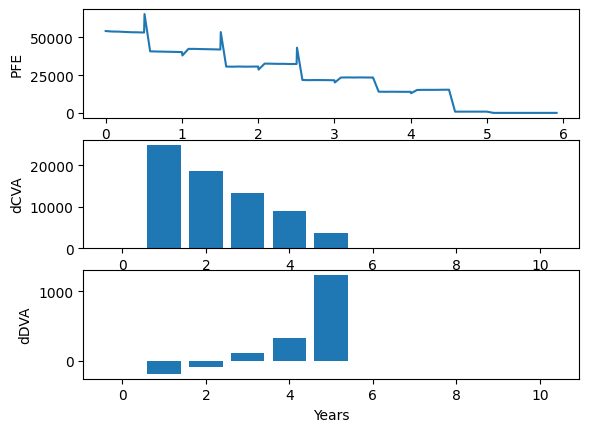

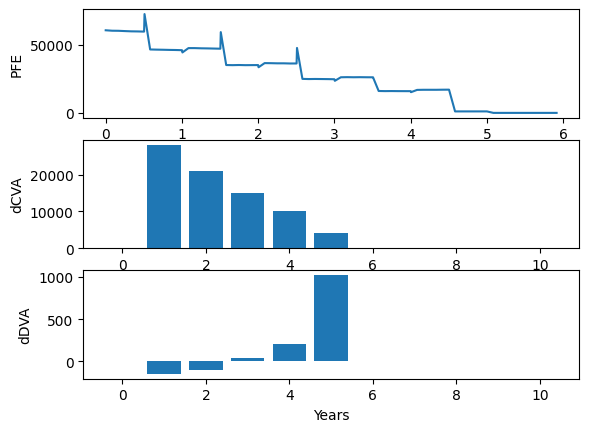

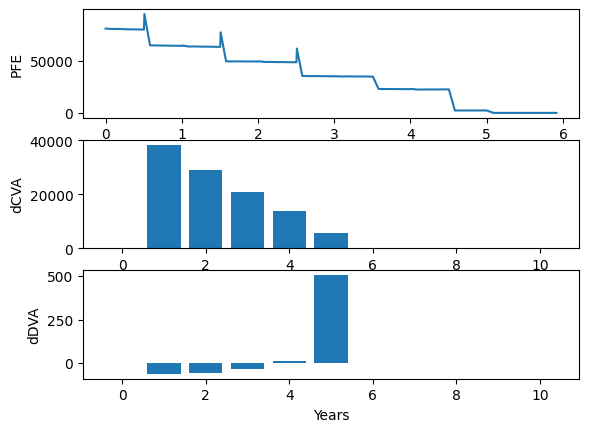

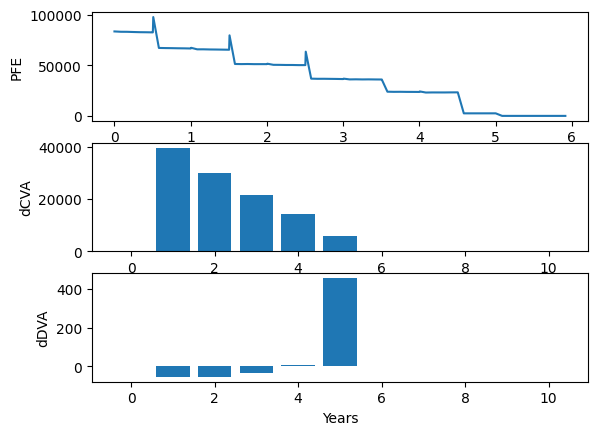

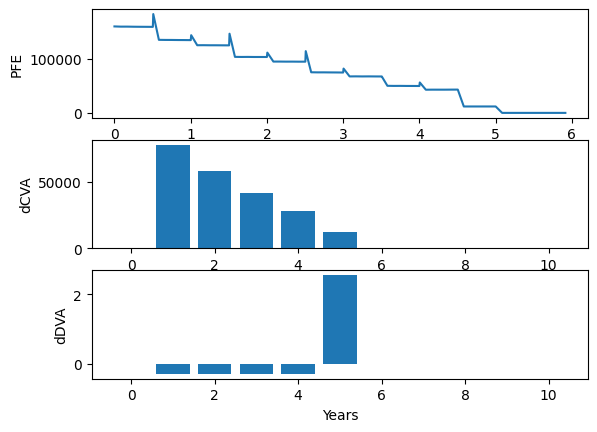

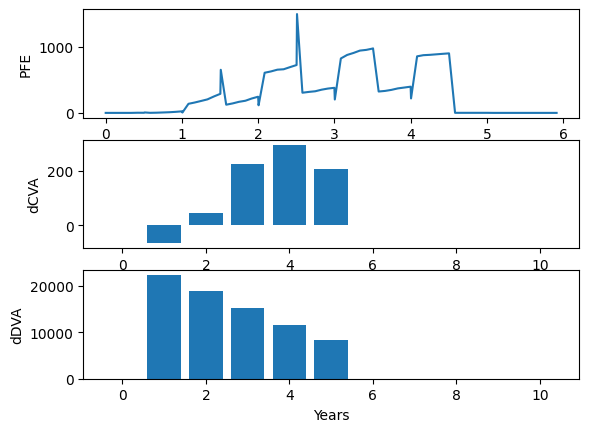

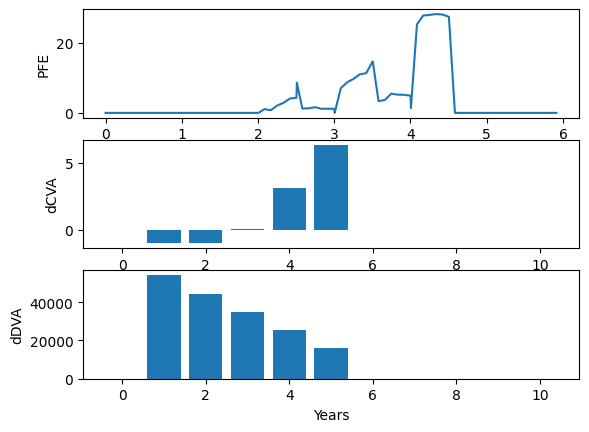

In [40]:
def recalc(rate_shift):
    inputs[rate_arg] = rate_value+rate_shift/100
    t0 = pc()
    results = aadc.evaluate(funcs, request, inputs, aadc.ThreadPool(10))
    print("evaluation time = ", pc() - t0, "sec")
    for i in range(len(discounted_portfolio_npv_res)):
        aadc_discounted_portfolio_npv[i] = results[0][discounted_portfolio_npv_res[i]]
    expected_discounted_exposure = calculate_expected_exposure(aadc_discounted_portfolio_npv, number_of_paths)

    plt.subplot(3,1,1)
    plt.plot(evaluation_time_grid, expected_discounted_exposure)
    plt.xlabel("Years")
    plt.ylabel("PFE")

    cva_hazard_rates_delta = np.zeros(np.shape(hazard_rates_arg))
    for i in range(len(hazard_rates_arg)):
        cva_hazard_rates_delta[i] = np.average(results[1][economic_cva_res][hazard_rates_arg[i]])
    dva_hazard_rates_delta = np.zeros(np.shape(hazard_rates_arg))
    for i in range(len(hazard_rates_arg)):
        dva_hazard_rates_delta[i] = np.average(results[1][economic_dva_res][hazard_rates_arg[i]])
    plt.subplot(3,1,2)
    plt.bar(list(range(len(hazard_rates_arg))), cva_hazard_rates_delta)
    plt.xlabel("Years")
    plt.ylabel("dCVA")
    plt.subplot(3,1,3)
    plt.bar(list(range(len(hazard_rates_arg))), dva_hazard_rates_delta)
    plt.xlabel("Years")
    plt.ylabel("dDVA")

    print("CVA:", np.average(results[0][economic_cva_res]))
    print("DVA:", np.average(results[0][economic_dva_res]))


widgets.interact(recalc, rate_shift=(-5, 10, 0.00005))